In [51]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [52]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [53]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))

In [54]:

def add_noise(input_data, corruption_level):
    """Introduce corruption into the input data `input_data` by adding noise based on `corruption_level`"""
    noise = torch.rand_like(input_data)
    corruption_level = corruption_level.view(-1, 1, 1, 1)
    corrupted_data = input_data * (1 - corruption_level) + noise * corruption_level
    return corrupted_data


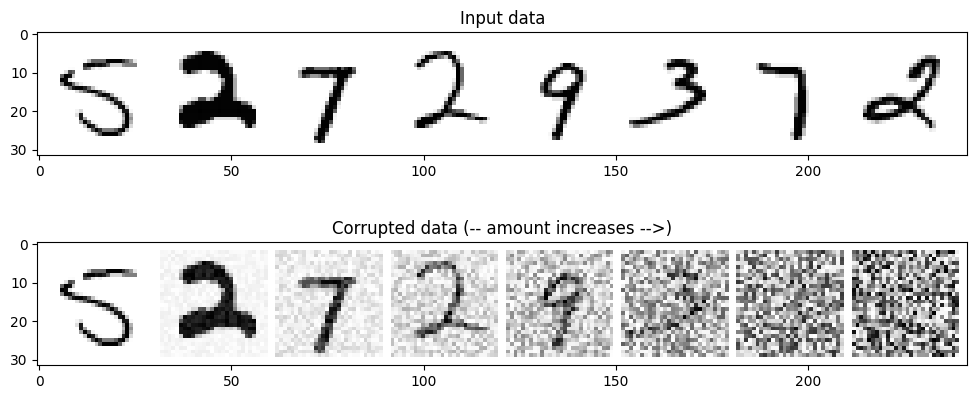

In [57]:


def plot_data_with_corruption(x):
    """Plot the input data and its corrupted version."""
    fig, axs = plt.subplots(2, 1, figsize=(12, 5))
    axs[0].set_title('Input data')
    axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

    corruption_levels = torch.linspace(0, 1, x.shape[0]) # From left to right, more corruption
    corrupted_x = add_noise(x, corruption_levels)

    axs[1].set_title('Corrupted data (-- amount increases -->)')
    axs[1].imshow(torchvision.utils.make_grid(corrupted_x)[0], cmap='Greys')

plot_data_with_corruption(x)

In [59]:


class BasicUNet(nn.Module):
    """A custom implementation of the UNet architecture."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.activation = nn.SiLU() # Using SiLU as the activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        skip_connections = []
        for i, layer in enumerate(self.down_layers):
            x = self.activation(layer(x))
            if i < 2:
                skip_connections.append(x)
                x = self.downscale(x)
              
        for i, layer in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += skip_connections.pop()
            x = self.activation(layer(x))
            
        return x


Finished epoch 0. Average loss for this epoch: 0.025791
Finished epoch 1. Average loss for this epoch: 0.019774
Finished epoch 2. Average loss for this epoch: 0.018270
Finished epoch 3. Average loss for this epoch: 0.017420
Finished epoch 4. Average loss for this epoch: 0.017095
Finished epoch 5. Average loss for this epoch: 0.016661
Finished epoch 6. Average loss for this epoch: 0.016373
Finished epoch 7. Average loss for this epoch: 0.016190
Finished epoch 8. Average loss for this epoch: 0.016117
Finished epoch 9. Average loss for this epoch: 0.015618


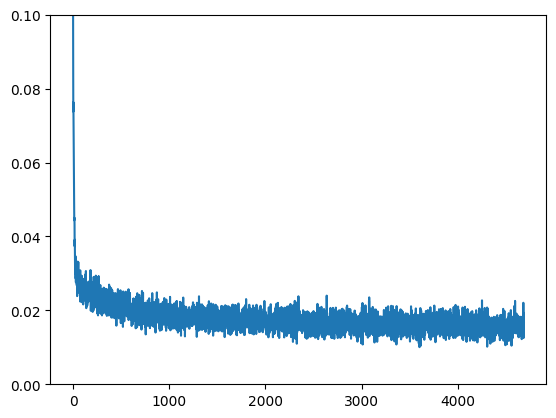

In [44]:


# DataLoader (batch size can be adjusted)
batch_size = 128
training_data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Number of epochs
num_epochs = 10

# Instantiate the network
model = BasicUNet()
model.to(device)

# Loss function
loss_function = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

# Record losses for visualization
losses = []

# Training loop
for epoch in range(num_epochs):

    for inputs, targets in training_data_loader:

        # Prepare the data and introduce corruption
        inputs = inputs.to(device) 
        noise_levels = torch.rand(inputs.shape[0]).to(device)
        corrupted_inputs = add_noise(inputs, noise_levels) 

        # Get model predictions
        predictions = model(corrupted_inputs)

        # Calculate loss
        loss = loss_function(predictions, inputs) 

        # Backpropagation and parameter update:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

    # Print the average loss for the epoch:
    average_loss = sum(losses[-len(training_data_loader):])/len(training_data_loader)
    print(f'Epoch {epoch} completed. Average loss for this epoch: {average_loss:05f}')

# Visualize the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);


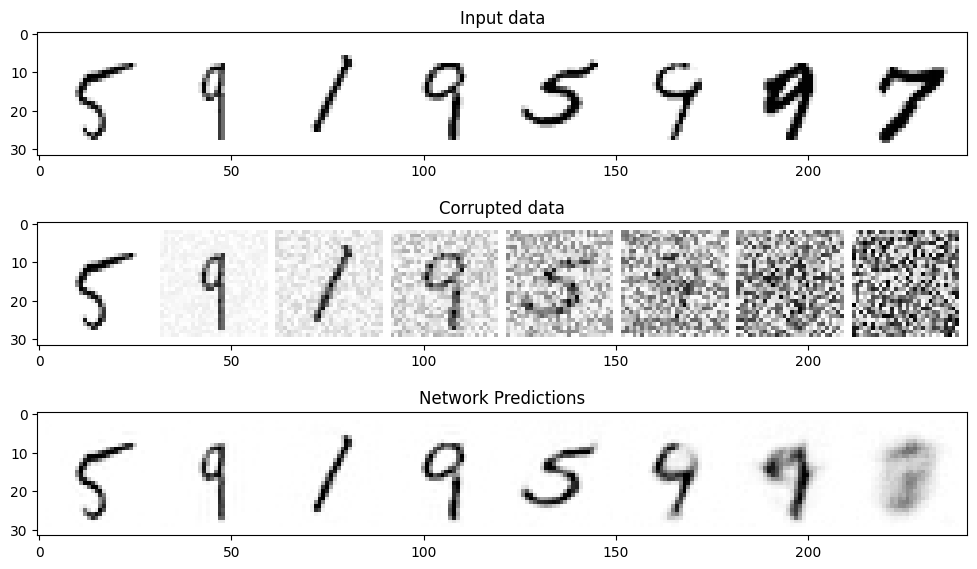

In [46]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
inputs, targets = next(iter(training_data_loader))
inputs = inputs[:8] # Selecting only the first 8 samples for easier plotting

# Introduce corruption with varying amounts
corruption_levels = torch.linspace(0, 1, inputs.shape[0]) # From left to right, increasing corruption
corrupted_inputs = add_noise(inputs, corruption_levels)

# Obtain model predictions
with torch.no_grad():
  predictions = model(corrupted_inputs.to(device)).detach().cpu()

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(inputs)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(corrupted_inputs)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Model Predictions')
axs[2].imshow(torchvision.utils.make_grid(predictions)[0].clip(0, 1), cmap='Greys');

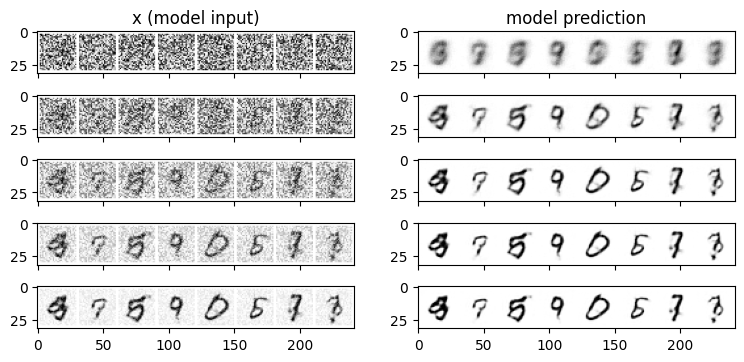

In [47]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = model(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

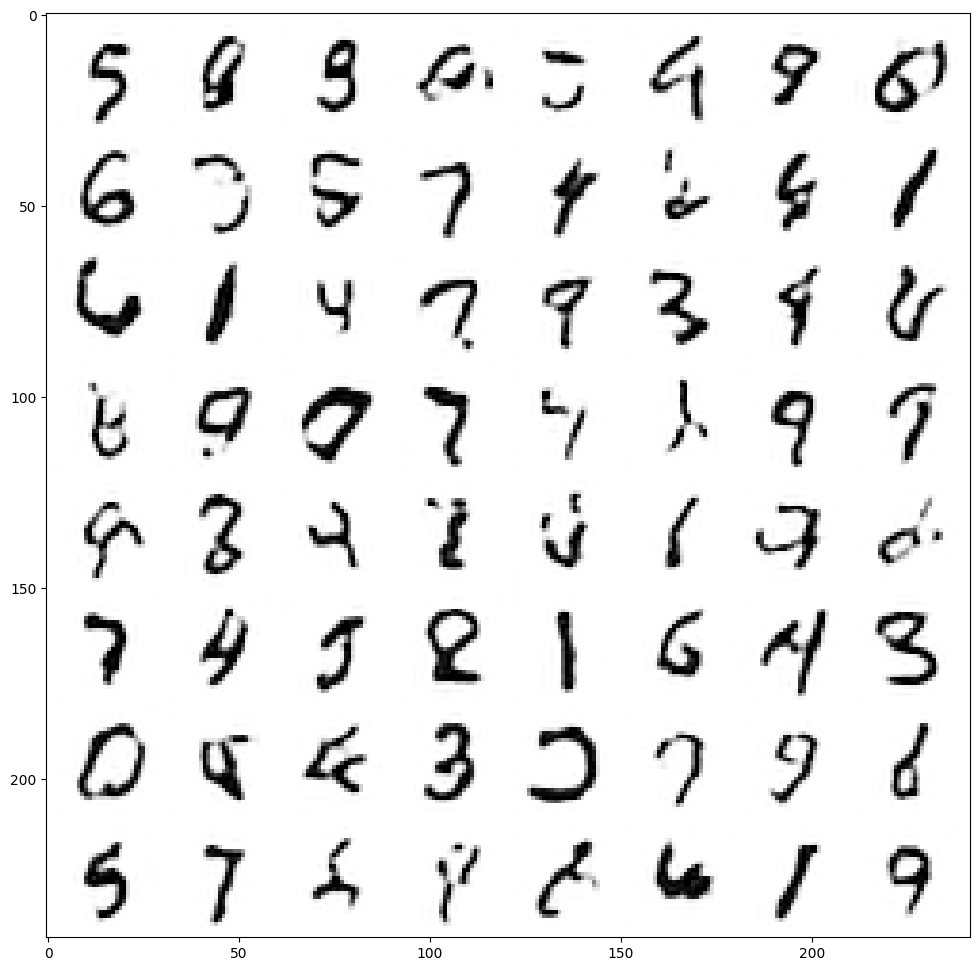

In [50]:
#@markdown Showing more results, using 40 sampling steps
import torchvision
import os

# Créez un dossier pour sauvegarder les images générées s'il n'existe pas déjà
output_folder = 'generated_images_basic_unet'
os.makedirs(output_folder, exist_ok=True)
n_steps = 20
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = model(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

for j in range(180):
    x = torch.rand(64, 1, 28, 28).to(device)
    for i in range(n_steps):
        noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
        with torch.no_grad():
            pred = net(x)
        mix_factor = 1/(n_steps - i)
        x = x*(1-mix_factor) + pred*mix_factor
    for k, image in enumerate(x.detach().cpu()):
        # Utilisez le format de nommage souhaité pour vos fichiers
        nb=k+j*64
        image_name = f'generated_image_{nb}.png'
        # Enregistrez l'image dans le dossier de sortie
        torchvision.utils.save_image(image, os.path.join(output_folder, image_name))

In [61]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)

In [ ]:
#@markdown Trying UNet2DModel instead of BasicUNet:

# DataLoader (batch size can be adjusted)
batch_size = 128
training_data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Number of epochs
num_epochs = 3

# Create the network
model = UNet2DModel(
    sample_size=28,  
    in_channels=1,  
    out_channels=1,  
    layers_per_block=2,  
    block_out_channels=(32, 64, 64),  
    down_block_types=( 
        "DownBlock2D",  
        "AttnDownBlock2D",  
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  
        "UpBlock2D",   
      ),
)
model.to(device)

# Loss function
loss_function = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

# Record losses for visualization
losses = []

# Training loop
for epoch in range(num_epochs):

    for inputs, targets in training_data_loader:

        # Prepare the data and introduce corruption
        inputs = inputs.to(device) 
        noise_levels = torch.rand(inputs.shape[0]).to(device) 
        corrupted_inputs = add_noise(inputs, noise_levels) 

        # Get model predictions
        with torch.no_grad():
            predictions = model(corrupted_inputs, 0).sample

        # Calculate loss
        loss = loss_function(predictions, inputs) 

        # Backpropagation and parameter update:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

    # Print the average loss for the epoch:
    average_loss = sum(losses[-len(training_data_loader):])/len(training_data_loader)
    print(f'Epoch {epoch} completed. Average loss for this epoch: {average_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
num_steps = 40
input_samples = torch.rand(64, 1, 28, 28).to(device)
for i in range(num_steps):
    noise_levels = torch.ones((input_samples.shape[0], )).to(device) * (1-(i/num_steps)) 
    with torch.no_grad():
        predictions = model(input_samples, 0).sample
    mix_factor = 1/(num_steps - i)
    input_samples = input_samples*(1-mix_factor) + predictions*mix_factor

axs[1].imshow(torchvision.utils.make_grid(input_samples.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');


: 